In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score

In [2]:
def mode_ties(s):
    m = s.mode()
    if len(m) > 1:
        random.shuffle(m)
        return(m[0])
    return m

def read_df(task):
    df_answer = pd.read_csv('../data/clean/answer_' + task + '.csv')
    df_truth = pd.read_csv('../data/clean/truth_' + task + '.csv').set_index('question')
    df_full = df_answer.join(df_truth, on='question', how='inner')
    return(df_full)

def get_mv(task):
    df_answer = pd.read_csv('../data/clean/answer_' + task + '.csv')
    df_answer = df_answer[['question', 'answer']].groupby('question').agg(mode_ties)

    df_truth = pd.read_csv('../data/clean/truth_' + task + '.csv')
    df_truth = df_truth.set_index('question')

    df_full = df_answer.join(df_truth, on='question', how='inner')
    acc = accuracy_score(df_full['answer'], df_full['truth'])
    return(acc)

def get_mv_noise(task, noise_level):
    df_answer = pd.read_csv('../data/noise/DIST/answer_' + task + '_noise' + str(noise_level) + '.csv')
    df_answer = df_answer[['question', 'answer']].groupby('question').agg(mode_ties)

    df_truth = pd.read_csv('../data/clean/truth_' + task + '.csv')
    df_truth = df_truth.set_index('question')

    df_full = df_answer.join(df_truth, on='question', how='inner')
    acc = accuracy_score(df_full['answer'], df_full['truth'])
    return(acc)

def get_mv_noise2(task, noise_level, sigma):
    df_answer = pd.read_csv('../data/noise2/DIST/answer_' + task + '_noise' + str(noise_level) + '_var' + str(sigma) + '.csv')
    df_answer = df_answer[['question', 'answer']].groupby('question').agg(mode_ties)

    df_truth = pd.read_csv('../data/clean/truth_' + task + '.csv')
    df_truth = df_truth.set_index('question')

    df_full = df_answer.join(df_truth, on='question', how='inner')
    acc = accuracy_score(df_full['answer'], df_full['truth'])
    return(acc)

In [38]:
def get_mv_levels(test_task, sigma):
    mv_scores = {}
    for l in range(35, 105, 10):
        lfloat = float(l)
        lfrac = lfloat/100
        mv_scores[lfrac] = get_mv_noise2(test_task, lfrac, sigma)
    return(mv_scores)
    
# test_tasks = ['adult_ordinal', 'waterbird', 'face', 'temporal', 'movie', 'dog', 'weather_ordinal']
# test_tasks = ['adult_ordinal', 'face', 'dog', 'waterbird', 'movie']
test_tasks = ['face', 'waterbird', 'adult_ordinal']
sigmas = [0.05, 0.15, 0.25, 0.35]
for sigma in sigmas:
    mv_noise_results = {}
    for test_task in test_tasks:
        df_full = read_df(test_task)
        labels_per_item = len(df_full) / df_full['question'].nunique() 
        items_per_worker = len(df_full) / df_full['worker'].nunique()
        # L/Q (info about each Q), L/W (info about each worker)
        label_text = test_task + " " + str(labels_per_item) + ", " + str(items_per_worker)
        mv_noise_results[label_text] = get_mv_levels(test_task, sigma)

    # print(mv_noise_results)
    mv_noise_df = pd.DataFrame.from_dict(mv_noise_results)
    print("SIGMA:", sigma)
    print(mv_noise_df)
    print("")

('SIGMA:', 0.05)
      adult_ordinal 10, 12  face 8, 194  waterbird 39, 108
0.35              0.490566     0.482877           0.009259
0.45              0.682390     0.640411           0.231481
0.55              0.902516     0.851027           0.750000
0.65              0.971698     0.974315           0.981481
0.75              0.993711     0.998288           1.000000
0.85              0.996855     1.000000           1.000000
0.95              1.000000     1.000000           1.000000

('SIGMA:', 0.15)
      adult_ordinal 10, 12  face 8, 194  waterbird 39, 108
0.35              0.506289     0.404110           0.046296
0.45              0.713836     0.438356           0.259259
0.55              0.883648     0.821918           0.731481
0.65              0.937107     0.986301           0.981481
0.75              0.990566     1.000000           1.000000
0.85              0.993711     1.000000           1.000000
0.95              1.000000     1.000000           1.000000

('SIGMA:', 0.25)
   

In [11]:
def get_ds_supervision(task):
    df_ds = pd.read_csv('../results-dump/DawidSkene/results-supervised/DS/results_supervised_' + task + '.csv')[['level', 'accuracy']]
    df_ds.columns = ['supervision_level', 'ds']
    df_ds = df_ds.groupby('supervision_level').mean()
    return df_ds

def get_mace_supervision(task):
    df_mace = pd.read_csv('../results-dump/MACE/results-supervised/results_supervised_' + task + '.csv')[['level', 'accuracy']]
    df_mace.columns = ['supervision_level', 'mace']
    df_mace = df_mace.groupby('supervision_level').mean()
    return df_mace


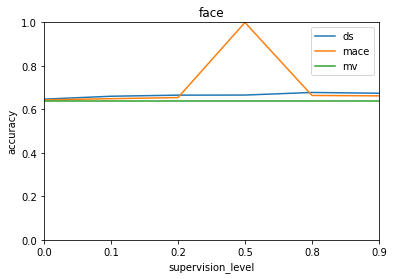

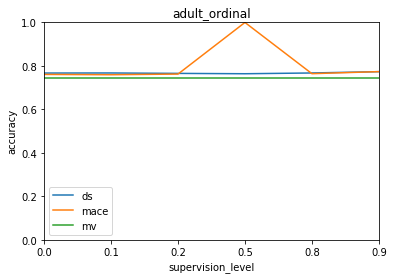

In [7]:
tasks = ['face', 'adult_ordinal']

for task in tasks:
    df_ds = get_ds_supervision(task)
    df_mace = get_mace_supervision(task)

    df = df_ds.join(df_mace, how='inner')
    df['mv'] = get_mv(task)

    df.index = df_ds.index.astype(str)
    ax = df.plot.line(title=task)
    ax.set_ylabel('accuracy')
    ax.set_ylim(0,1)

In [3]:
def get_ds_noise(task):
    df_ds = pd.read_csv('../results-dump/DawidSkene/results-noise-supervised/DS/results_noise_supervised_' + task + '.csv')[['level','noise_level', 'accuracy']]
    df_ds.columns = ['supervision_level','noise_level', 'ds']
    df_ds = df_ds.groupby(['noise_level', 'supervision_level']).mean()
    return df_ds

def get_mace_noise(task):
    df_mace = pd.read_csv('../results-dump/MACE/results-noise-supervised/results_noise_supervised_' + task + '.csv')[['level','noise_level', 'accuracy']]
    df_mace.columns = ['supervision_level','noise_level', 'mace']
    df_mace = df_mace.groupby(['noise_level', 'supervision_level']).mean()
    return df_mace

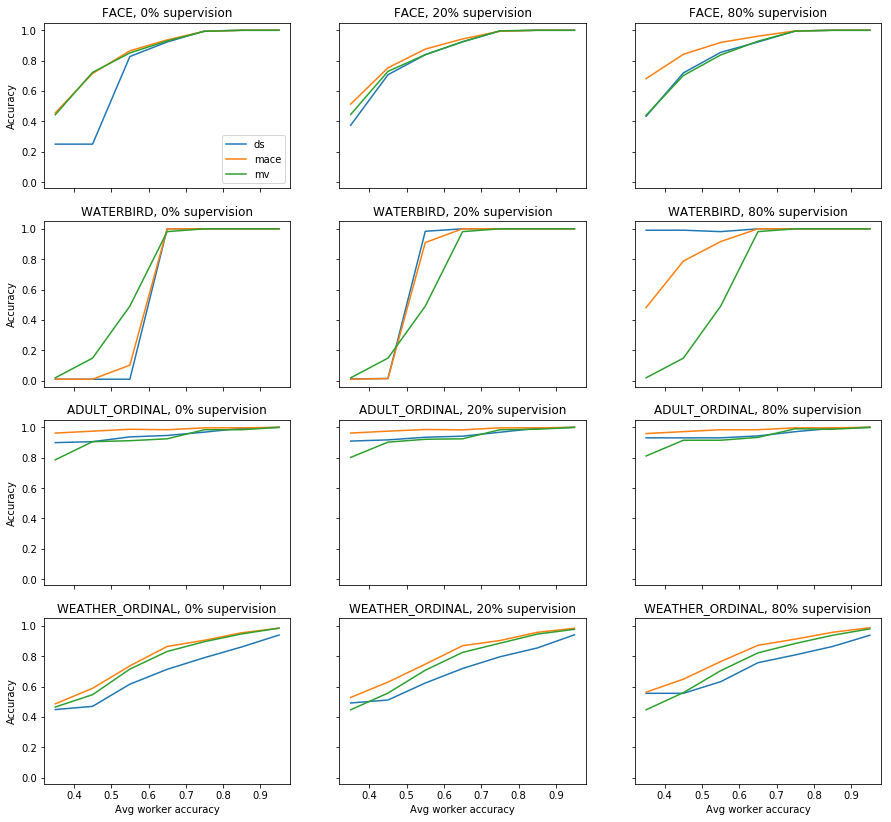

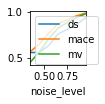

In [41]:
tasks = ['face', 'waterbird', 'adult_ordinal', 'weather_ordinal']
levels = [0.0, 0.2, 0.8]

width = len(levels) * 5
height = len(tasks) * 3.5
fig, axs = plt.subplots(len(tasks), len(levels), sharex=True, sharey=True, figsize=(width,height))

for i in range(len(tasks)):
    task = tasks[i]
    for j in range(len(levels)):
        level = levels[j]
        df_ds = get_ds_noise(task)
        df_mace = get_mace_noise(task)

        df = df_ds.join(df_mace, how='inner', lsuffix='_ds', rsuffix='_mace')
        df['mv'] = df.index.map(lambda x: get_mv_noise(task, x[0]))
        
        df.reset_index(inplace=True) 
        df_at_level = df[df['supervision_level'] == level].set_index('noise_level')[['ds', 'mace','mv']]

        axs[i,j].plot(df_at_level.index, df_at_level[['ds', 'mace', 'mv']])
        axs[i,j].set_title(task.upper() + ", " + str(int(level * 100)) + "% supervision")

ax = df_at_level.plot(figsize=(1,1))
h, l = ax.get_legend_handles_labels()
axs[0,0].legend(h,l,loc="lower right")


for i in range(len(tasks)):
    axs[i,0].set_ylabel('Accuracy')
    
for i in range(len(levels)):
    axs[len(tasks) - 1,i].set_xlabel('Avg worker accuracy')

In [4]:
def get_dist_noise(task, metric):
    df_dist = pd.read_csv('../results-dump/distance-based/results-noise-supervised/results_' + task + '.csv')
    df_dist = df_dist[['method','noise', metric]].groupby(['method','noise']).mean()
    return df_dist


In [20]:
tasks = ['face', 'adult_ordinal', 'waterbird', 'dog', 'weather_ordinal', 'movie', 'temporal']
metric = 'acc'
for i in range(len(tasks)):
    task = tasks[i]
    df_dist = get_dist_noise(task, metric)
    df_dist.reset_index(inplace=True)
    df_dist_pv = df_dist.pivot_table(index='noise', columns='method', values=metric)
    df_dist_pv['MV'] = df_dist_pv.index.map(lambda x: get_mv_noise(task, x))
    
    df_avg_perf = df_dist_pv.melt().groupby('method').mean()
    df_avg_perf = df_avg_perf[df_avg_perf.index != 'ORACLE']
    print(task)
    print(df_avg_perf)
    print('\n')
    
#     df_dist_pv = df_dist_pv[df_dist_pv.index > .5]

#     df_dist_pv.plot(title=task)


face
           value
method          
BAU     0.709149
DEM     0.845646
MAS     0.852984
MV      0.846624
RANDOM  0.654354
SAD     0.854207


adult_ordinal
           value
method          
BAU     0.964510
DEM     0.933962
MAS     0.979784
MV      0.931267
RANDOM  0.647350
SAD     0.928122


waterbird
           value
method          
BAU     0.658730
DEM     0.661376
MAS     0.656085
MV      0.662698
RANDOM  0.661376
SAD     0.662698


dog
           value
method          
BAU     0.867233
DEM     0.873252
MAS     0.893078
MV      0.869003
RANDOM  0.641352
SAD     0.867941


weather_ordinal
           value
method          
BAU     0.775602
DEM     0.785069
MAS     0.750000
MV      0.762478
RANDOM  0.643503
SAD     0.765491


movie
           value
method          
BAU     0.700286
DEM     0.707429
MAS     0.706857
MV      0.706571
RANDOM  0.646571
SAD     0.712000


temporal
           value
method          
BAU     0.696970
DEM     0.693568
MAS     0.700371
MV      0.696351
RANDOM